In [3]:
## Import system library
import os
import glob

## Import Image Processing library
import cv2
import numpy as np
from skimage import exposure
from skimage.color import rgb2gray
from skimage.filters import unsharp_mask
from skimage.filters import threshold_otsu
from skimage.morphology import disk, closing, dilation
import matplotlib.pyplot as plt
%matplotlib inline

from utils.preprocess import sliding_window

## Import machine learning library
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from utils.lbp import LBP
from utils.vis import draw_bboxes
from utils.dataset import load_yolo_labels
from utils.iou import iou, calculate_boxA_percentage
from utils.intensity_transforms import histogram_matching, calculate_mean_histogram


In [4]:
## Defind dataset folders

# root_path = '/content/drive/Shareddrives/Wrist_fracture_detectiom/ML/Dataset'
root_path = 'MLDataset/crop_data'

img_train_folder = 'train'
img_test_folder = 'test'
label_folder = 'labels'
image_folder = 'images'

## Histogram Matching

## Extract Features

In [6]:
stepSize = 128
windowSize = 256
save_path = 'MLDataset/grid_data'

In [12]:
### Extract LBP features and export to npy file
mode = 'test'

### Loop through all images
for idx, image_path in enumerate(glob.glob(os.path.join(root_path, image_folder, mode, '**/*.png'))):
    image_name = os.path.basename(image_path).replace('.png', '')
    print(f'Processing {image_name}...')
    
    ### Extract LBP features
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    label_path = image_path.replace('images', 'labels').replace('.png', '.txt')
    labels = []
    if os.path.exists(label_path):
        labels = load_yolo_labels(label_path, image.shape)
    
    for i, (x, y, window_img) in enumerate(sliding_window(image, stepSize=stepSize, windowSize=windowSize)):
        if window_img.shape[0] != windowSize or window_img.shape[1] != windowSize:
            continue
        save_name = f'{image_name}_{x}_{y}.'
        
        is_fracture = False
        
        new_labels = []
        for label in labels:
            c, *xyxy = label
            iou_score = calculate_boxA_percentage(xyxy, [x, y, x + windowSize, y + windowSize])
            if iou_score > 0.5:
                x1, y1, x2, y2 = xyxy
                x_1_n = max(x1 - x, 0)
                y_1_n = max(y1 - y, 0)
                x_2_n = min(x2 - x, windowSize)
                y_2_n = min(y2 - y, windowSize)
                xc = (x_1_n + x_2_n) / 2 / windowSize
                yc = (y_1_n + y_2_n) / 2 / windowSize
                w = (x_2_n - x_1_n) / windowSize
                h = (y_2_n - y_1_n) / windowSize
                new_labels.append([c, xc, yc, w, h])
                is_fracture = True
        
        class_name = 'fracture' if is_fracture else 'non_fracture'
        save_image_folder = os.path.join(save_path, image_folder, mode, class_name)
        save_label_folder = os.path.join(save_path, label_folder, mode, class_name)
        if not os.path.exists(save_image_folder):
            os.makedirs(save_image_folder)
        if not os.path.exists(save_label_folder):
            os.makedirs(save_label_folder)
        
        if len(new_labels) > 0:
            open(os.path.join(save_label_folder, save_name + 'txt'), 'w').write('\n'.join([' '.join(map(str, l)) for l in new_labels]))
                
        cv2.imwrite(os.path.join(save_image_folder, save_name + 'png'), window_img)
        


Processing 0045_0661159881_01_WRI-L1_M010...
Processing 0073_1210326335_02_WRI-R1_M017...
Processing 0087_0493070693_01_WRI-R2_F003...
Processing 0351_0798024563_01_WRI-R2_M014...
Processing 0669_0764349986_02_WRI-L1_F013...
Processing 0019_0224740760_01_WRI-R1_M009...
Processing 0022_0473957122_03_WRI-R2_M014...
Processing 0073_1156812570_01_WRI-L2_M015...
Processing 0074_0778270458_01_WRI-L1_F010...
Processing 0023_0657842010_02_WRI-L2_M012...
Processing 0386_0704200329_01_WRI-R2_M012...
Processing 0048_0915622108_02_WRI-L2_F014...
Processing 0002_0354485759_01_WRI-R2_F012...
Processing 0037_0894273521_01_WRI-R2_M015...
Processing 0072_0432564942_01_WRI-R1_M015...
Processing 0049_0920148982_01_WRI-L1_M012...
Processing 0061_0644271611_01_WRI-L2_F010...
Processing 0056_0422451576_03_WRI-L2_F012...
Processing 0052_1061971499_01_WRI-R1_F011...
Processing 0088_1103836952_01_WRI-L2_M017...
Processing 0417_0697542554_01_WRI-R1_F008...
Processing 0076_0818101753_01_WRI-R1_M014...
Processing

In [22]:
### Export to npy file normal
np.save(export_path_normal, np.array(non_fracture_features[:num_features]))

In [26]:
### Export to npy file fracture and non-fracture
np.save(export_path_fracture, fracture_features)
np.save(export_path_non_fracture, non_fracture_features)

## Machine Learning Model

### Load data

In [3]:
dataset_path = 'MLDataset/crop_data'

In [28]:
train_normal_features = np.load(os.path.join(dataset_path, 'train_normal_lbp.npy'))[:100]
train_non_fracture = np.load(os.path.join(dataset_path, 'train_non_fracture_lbp.npy'))[:100]
train_non_fracture_features = np.concatenate([train_normal_features, train_non_fracture])

train_fracture_features = np.load(os.path.join(dataset_path, 'train_fracture_lbp.npy'))[:200]
train_features = np.concatenate([train_non_fracture_features, train_fracture_features])
train_labels = np.array([0] * len(train_non_fracture_features) + [1] * len(train_fracture_features))

In [16]:
## Histogram of LBP features
train_features = [np.histogram(f.flatten(), bins=256, range=[0, 256])[0] for f in train_features]
test_features = [np.histogram(f.flatten(), bins=256, range=[0, 256])[0] for f in test_features]

In [29]:
import random
random.shuffle(list(range(len(train_features))))

train_features = train_features
train_labels = train_labels

# test_features = test_features
# test_labels = test_labels

In [30]:
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

### Training

In [31]:
model = SVC(kernel='linear')
# model = RandomForestClassifier(n_estimators=00, random_state=42, class_weight='balanced')
# model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train)

SVC(kernel='linear')

In [32]:
# Evaluate the model on the valid set
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print('f1-score:', f1_score(y_val, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.61      0.70      0.65        40
           1       0.65      0.55      0.59        40

    accuracy                           0.62        80
   macro avg       0.63      0.62      0.62        80
weighted avg       0.63      0.62      0.62        80

[[28 12]
 [18 22]]
f1-score: 0.6228786926461346


## Export the model

In [4]:
model_path = 'models/weights/svm.pkl'

In [11]:
### Export model
joblib.dump(model, model_path)

NameError: name 'model' is not defined

## Load the model

In [5]:
model = joblib.load(model_path)

## Testing

In [13]:
test_normal_features = np.load(os.path.join(dataset_path, 'test_normal_lbp.npy'))
test_non_fracture = np.load(os.path.join(dataset_path, 'test_non_fracture_lbp.npy'))
test_non_fracture_features = np.concatenate([test_normal_features, test_non_fracture])

test_fracture_features = np.load(os.path.join(dataset_path, 'test_fracture_lbp.npy'))
test_features = np.concatenate([test_non_fracture_features, test_fracture_features])
test_labels = np.array([0] * len(test_non_fracture_features) + [1] * len(test_fracture_features))

: 

In [6]:
test_features_npy = ['test_normal_lbp.npy', 'test_non_fracture_lbp.npy', 'test_fracture_lbp.npy']
classes = [0, 0, 1]

In [7]:
save_path = 'results'

for i, npy_file in enumerate(test_features_npy):
    test_features = np.load(os.path.join(dataset_path, npy_file))
    y_pred = model.predict(test_features)
    y_true = np.array([classes[i]] * len(test_features))
    result = np.vstack([y_true, y_pred])
    np.save(os.path.join(save_path, npy_file), result)
    print(f"Saved {npy_file}")

In [8]:
y_pred = []
y_true = []

for r_path in glob.glob(os.path.join(save_path, '*.npy')):
    result = np.load(r_path)
    y_true.extend(result[0,:].tolist())
    y_pred.extend(result[1,:].tolist())

In [9]:
# Evaluate the model on the valid set
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))
print('f1-score:', f1_score(y_true, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.86      0.49      0.62      2002
           1       0.23      0.65      0.34       470

    accuracy                           0.52      2472
   macro avg       0.54      0.57      0.48      2472
weighted avg       0.74      0.52      0.57      2472

[[ 978 1024]
 [ 163  307]]
f1-score: 0.5688303281791975


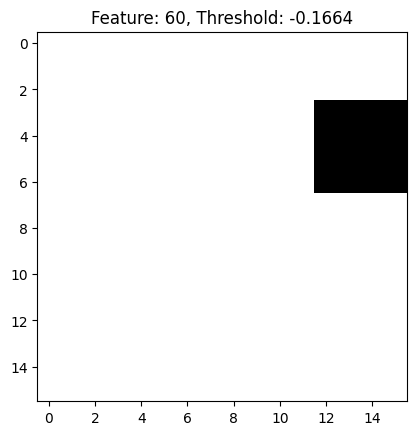

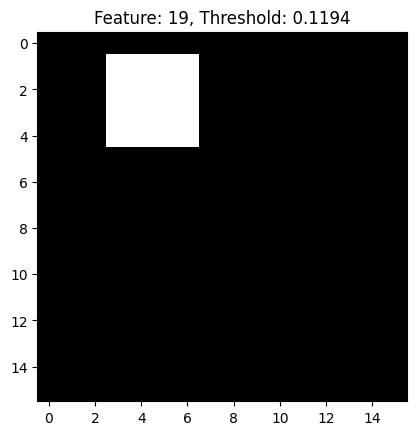

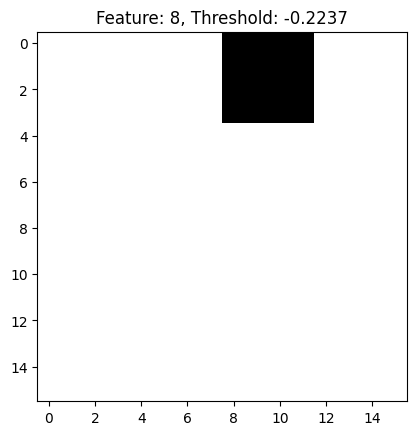

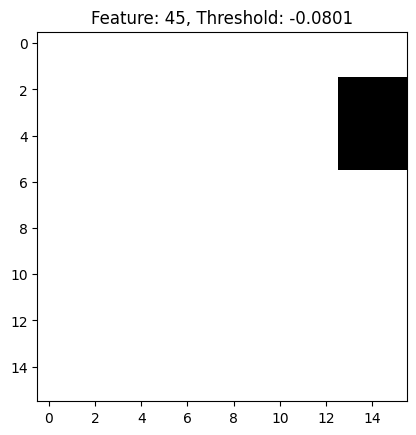

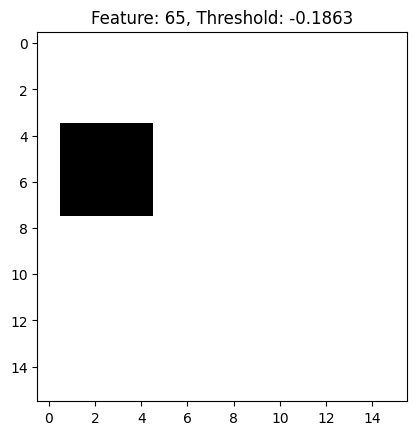

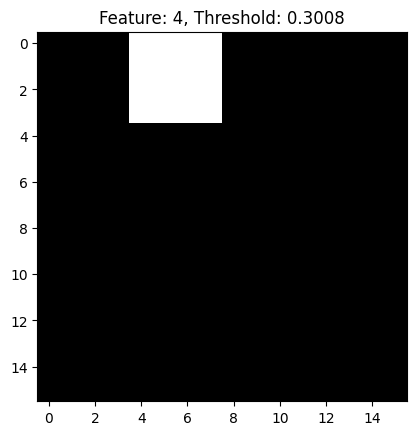

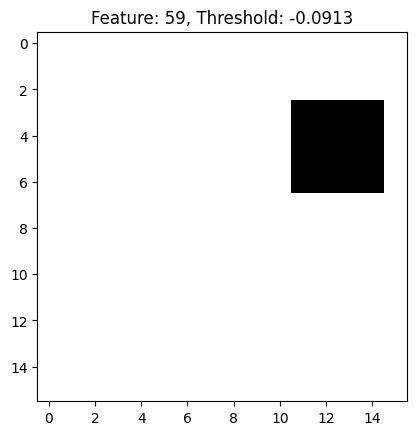

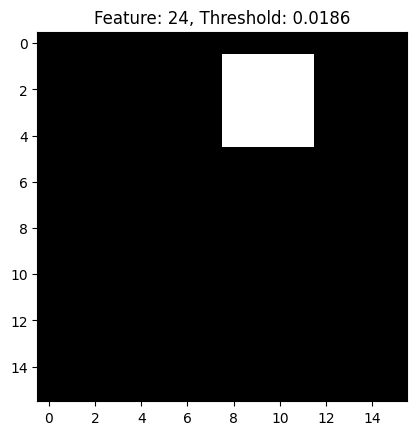

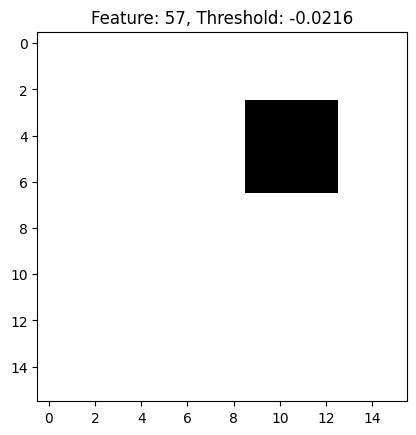

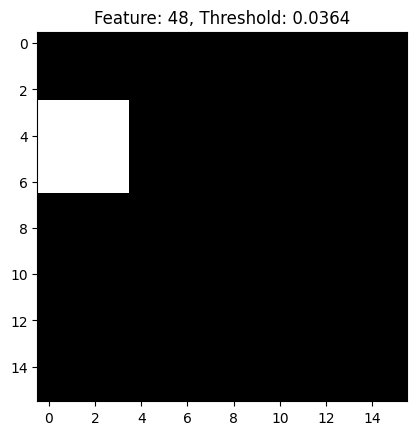

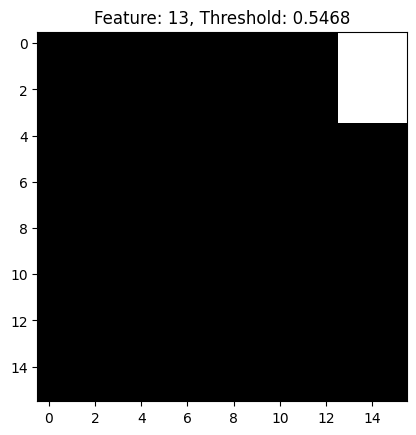

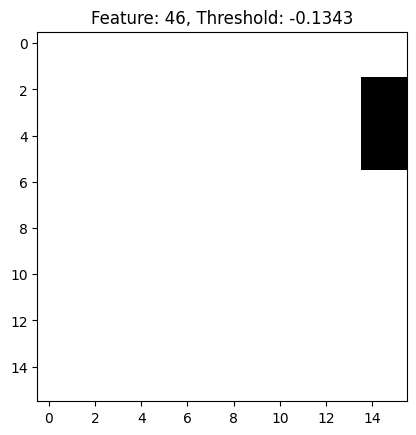

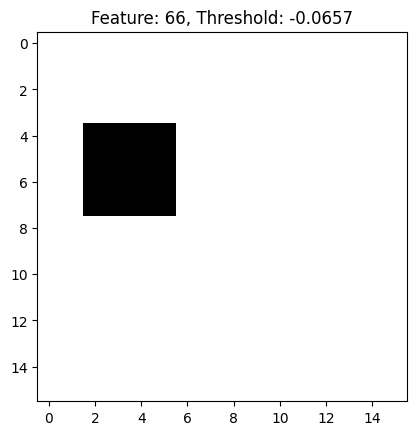

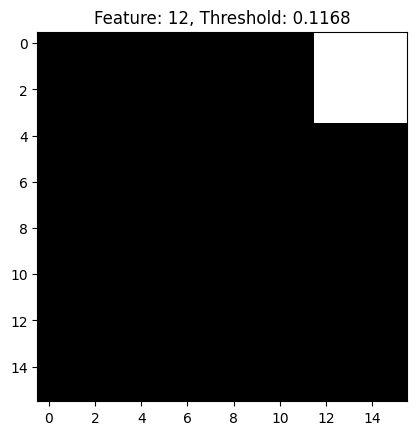

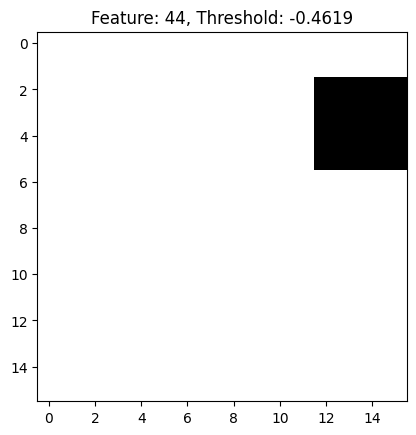

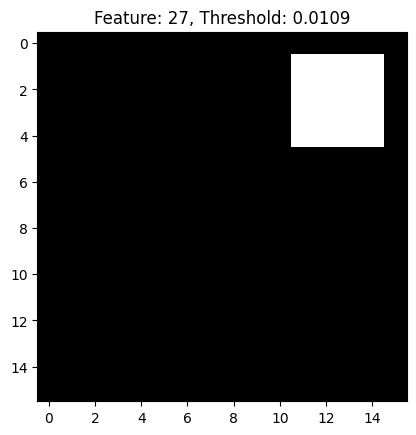

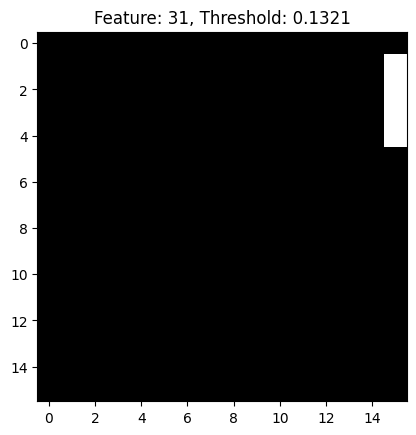

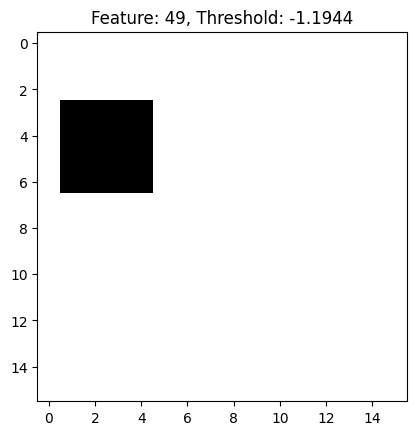

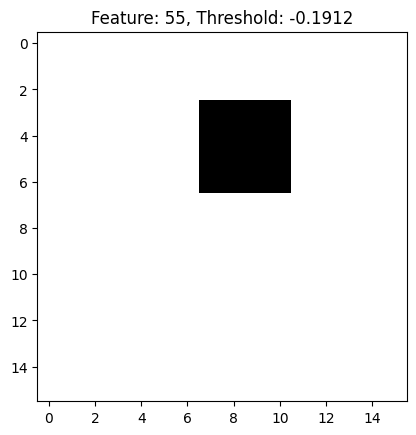

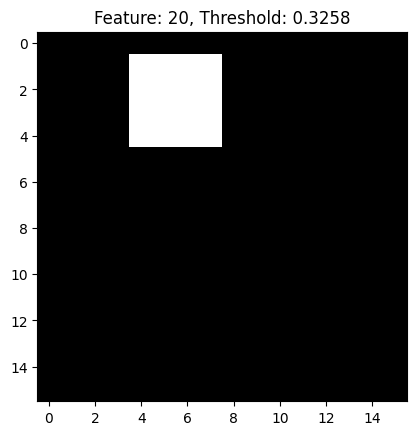

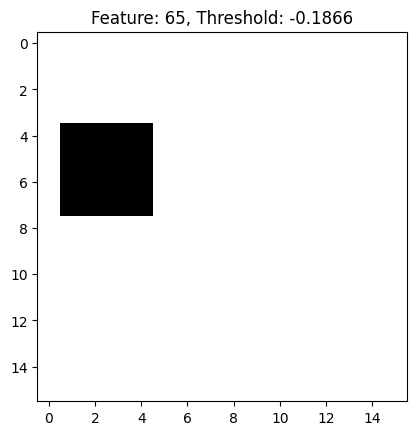

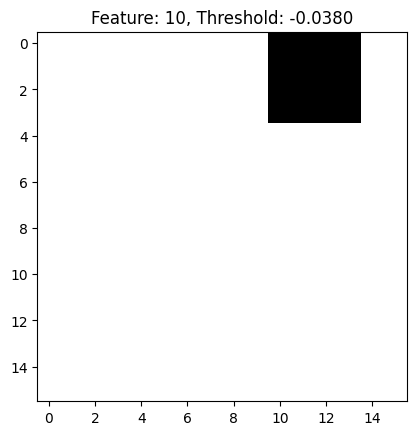

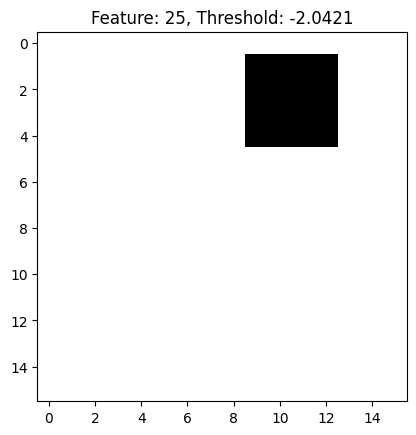

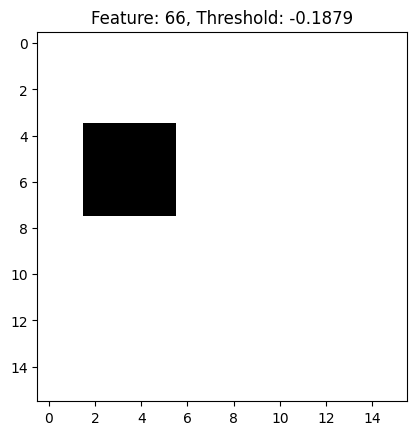

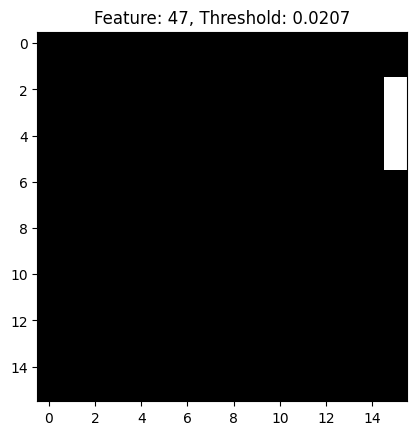

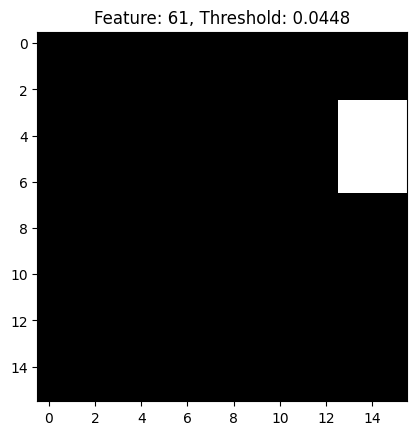

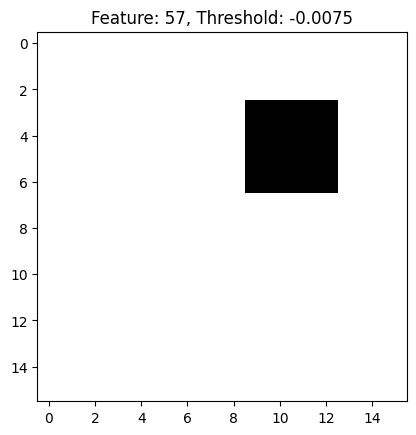

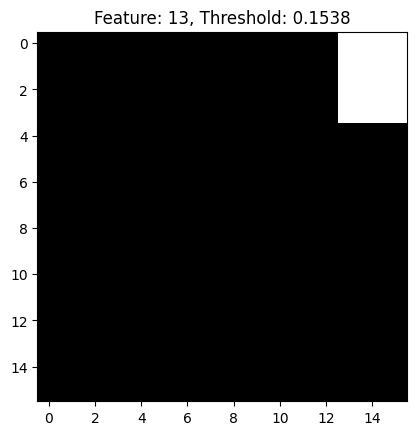

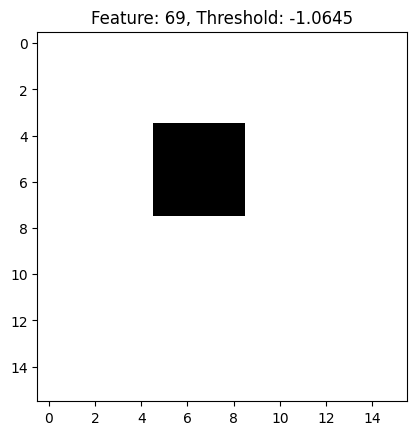

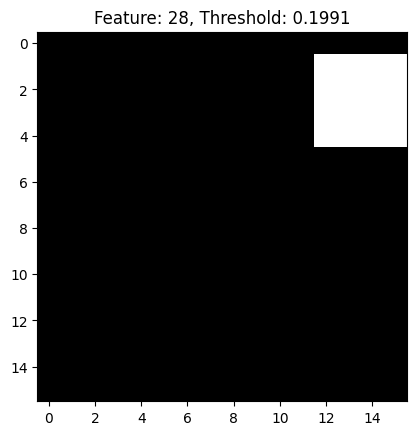

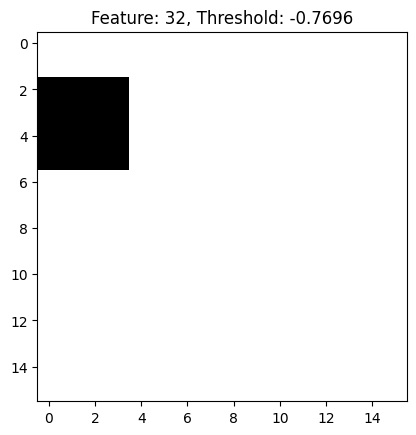

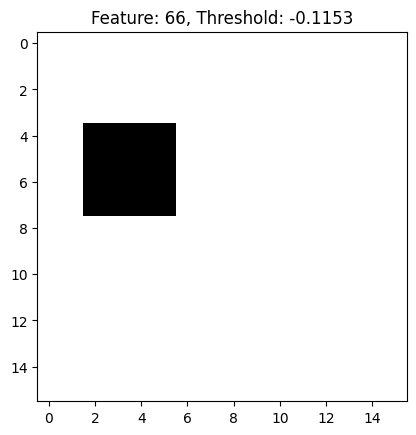

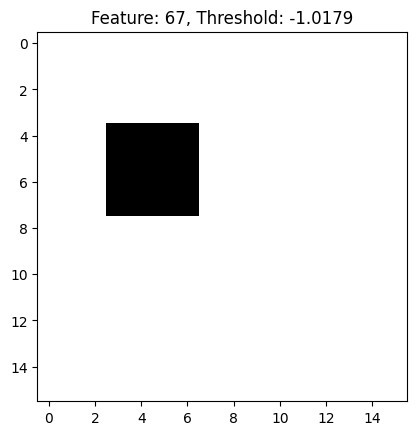

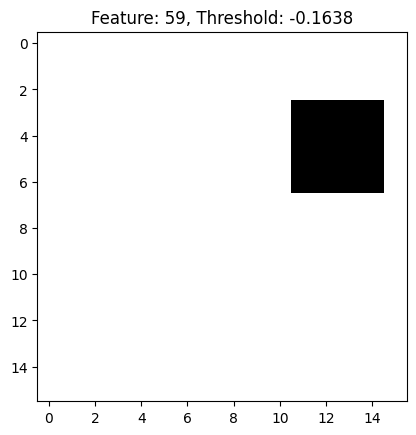

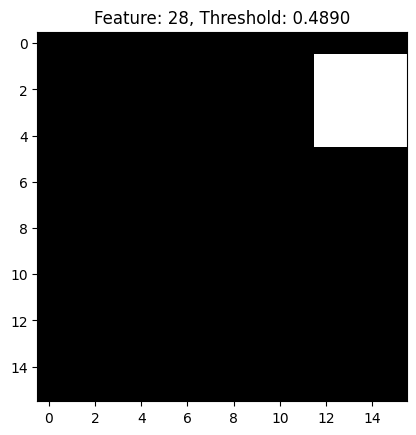

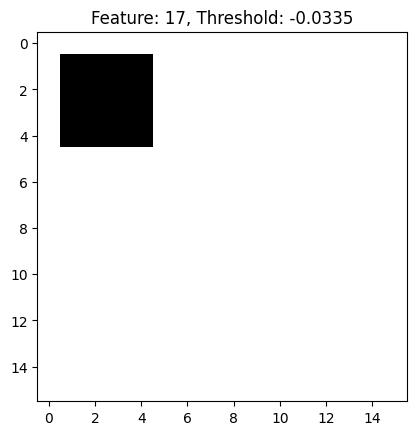

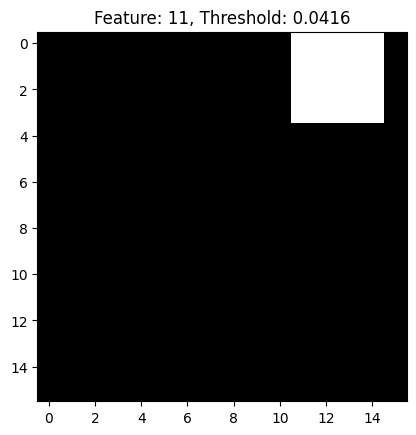

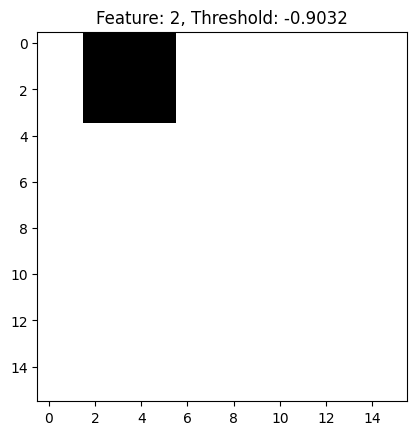

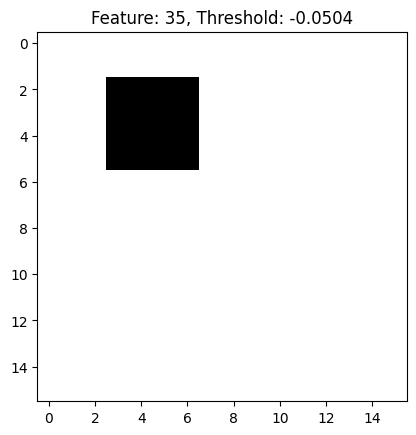

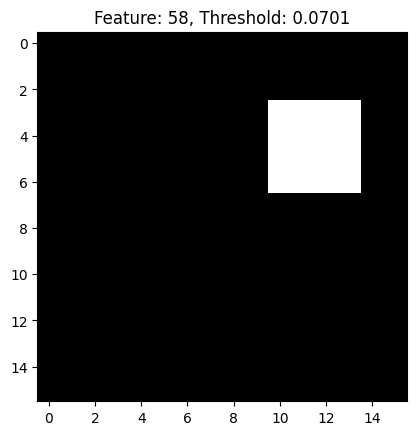

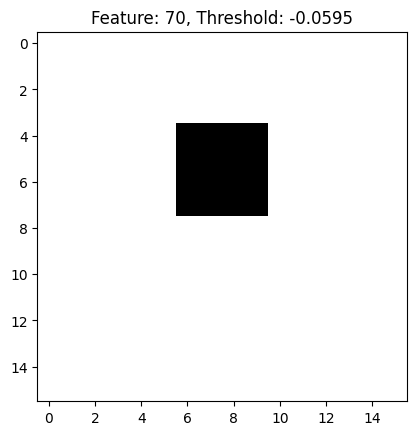

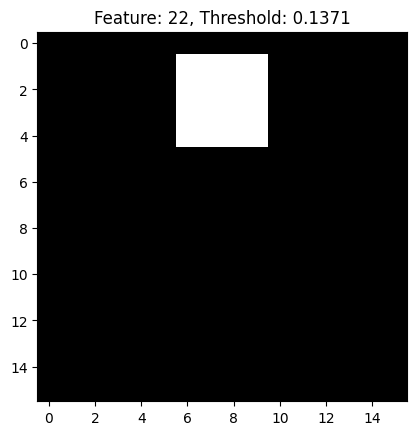

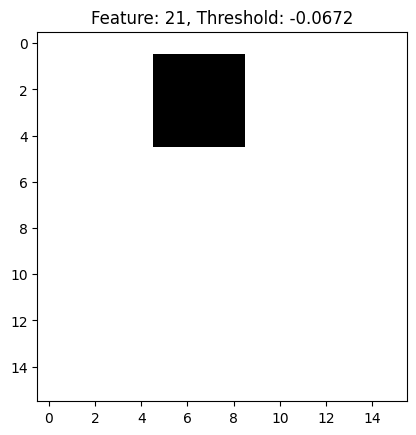

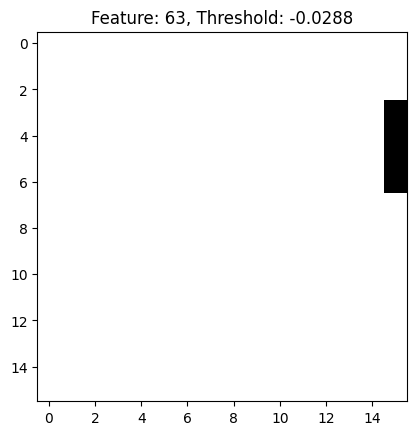

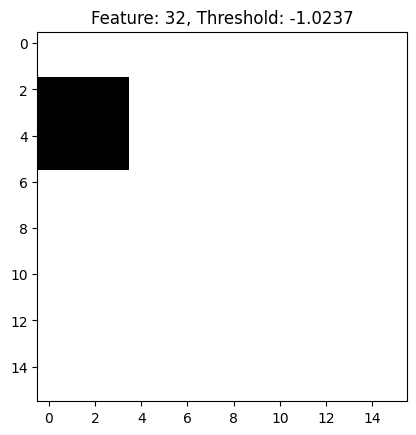

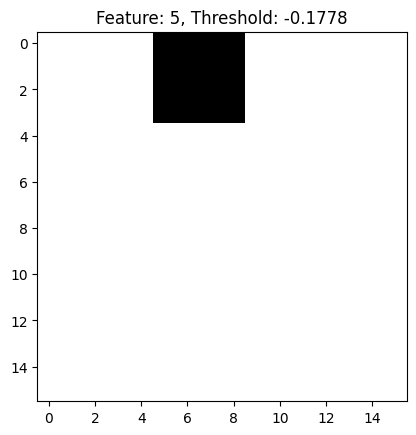

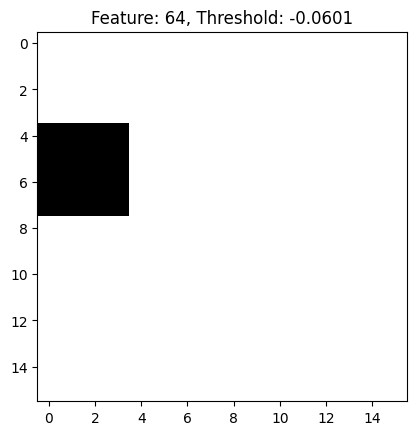

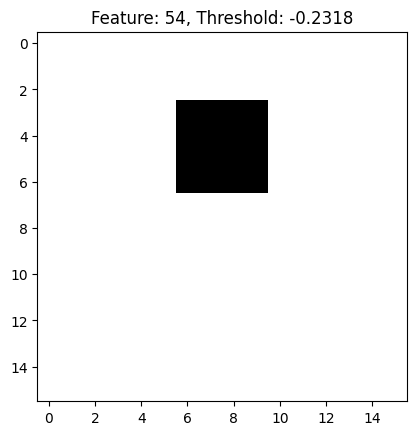

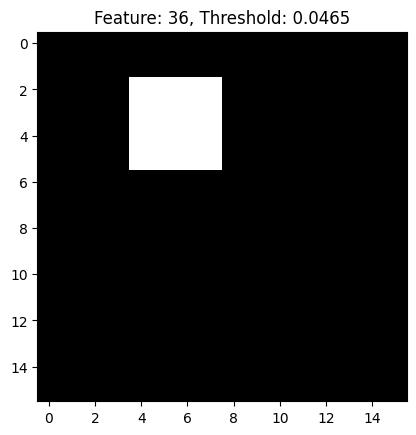

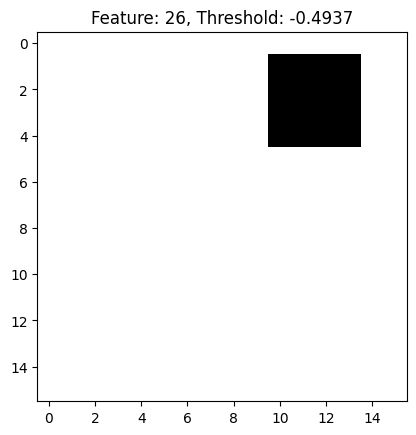

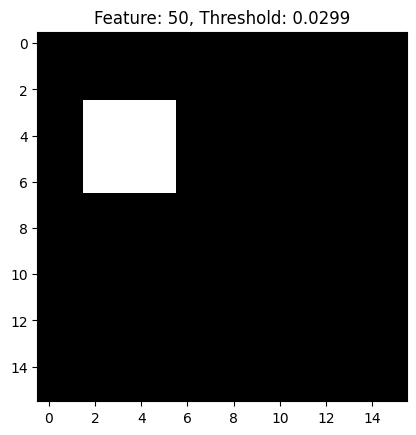

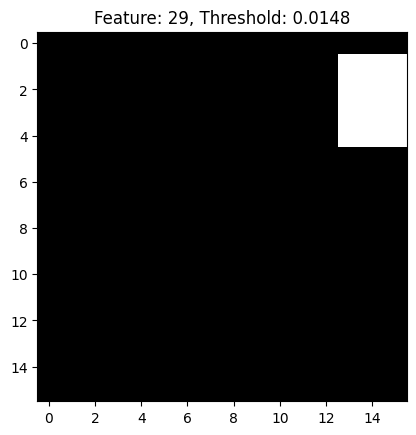

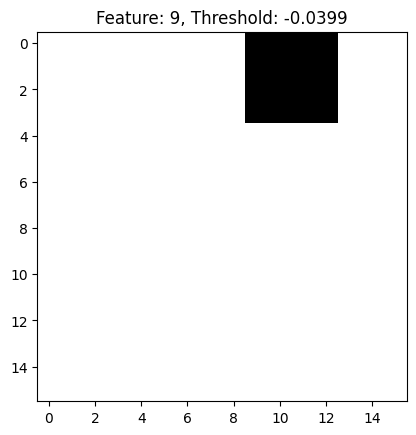

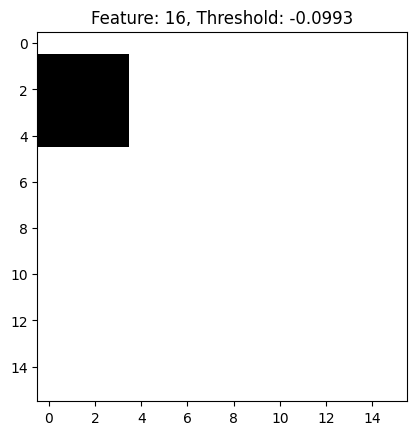

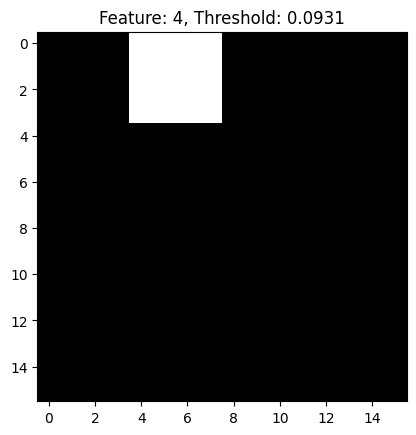

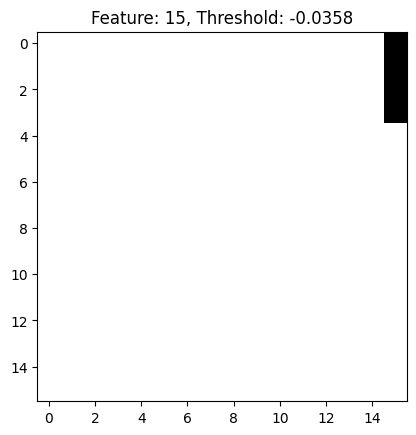

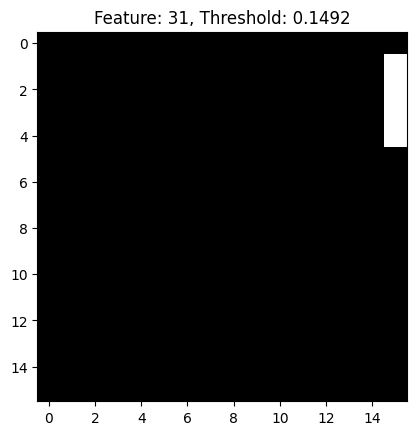

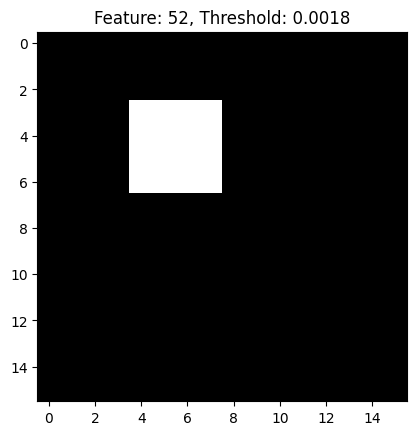

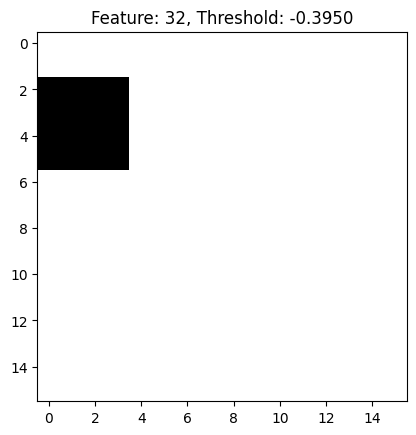

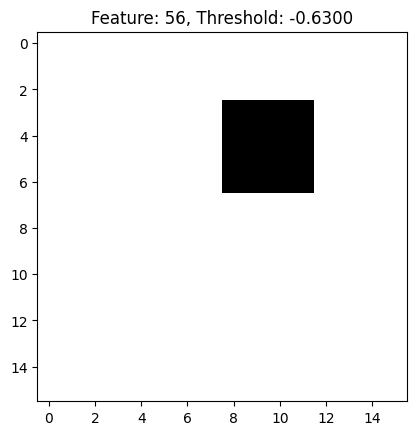

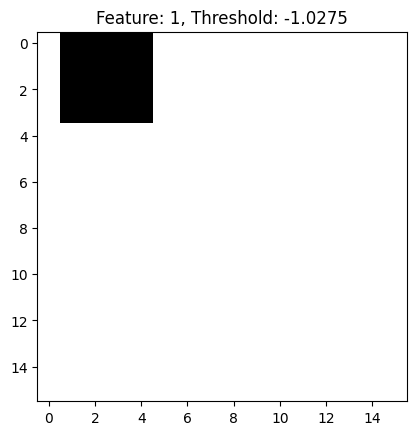

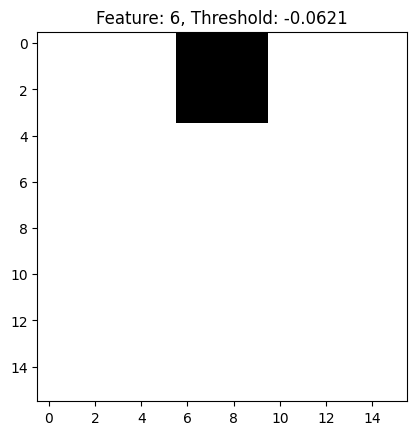

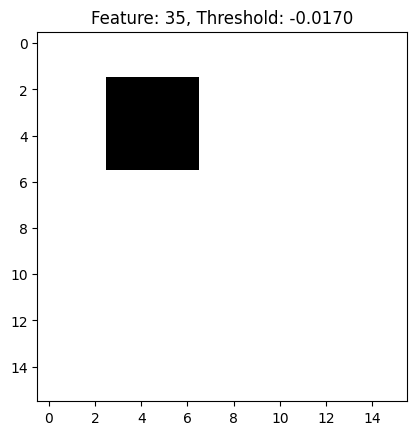

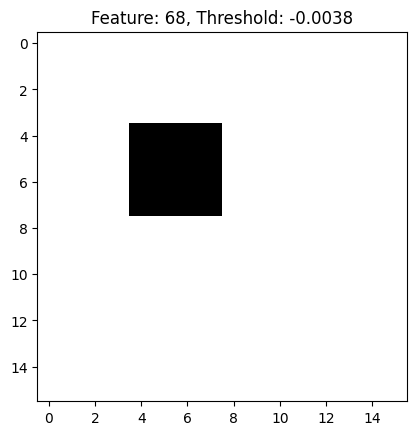

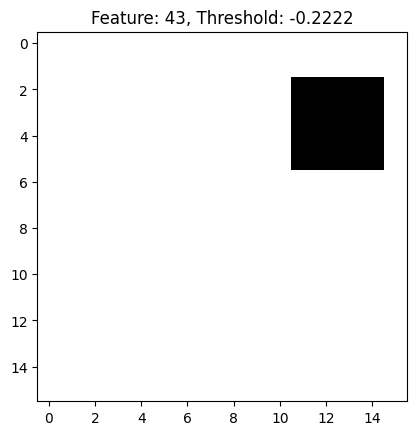

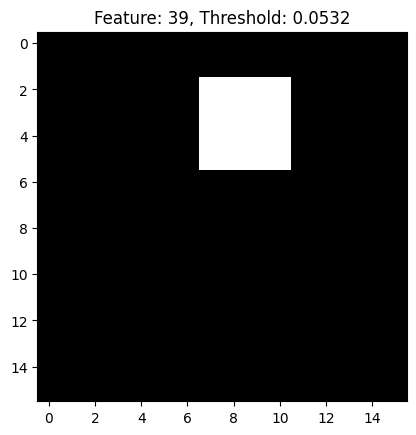

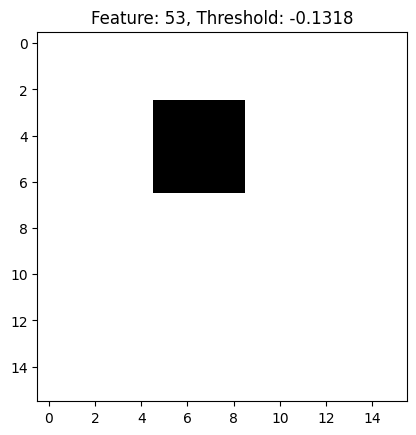

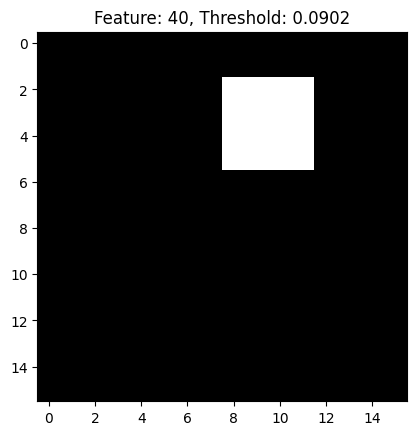

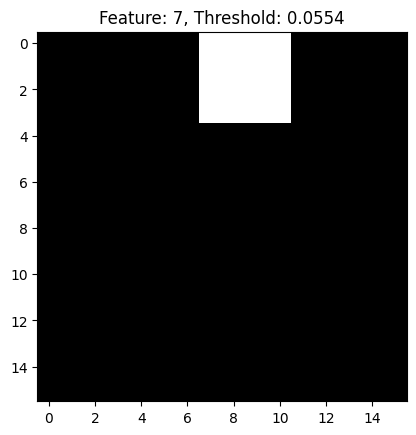

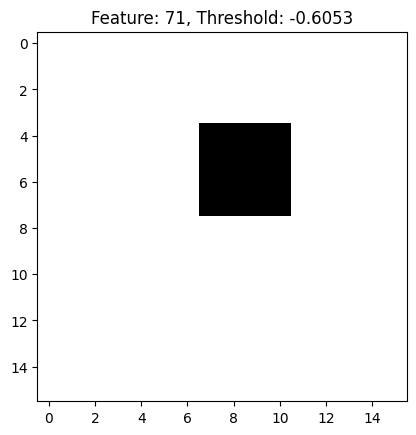

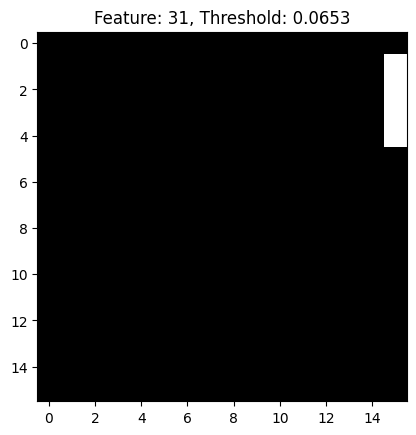

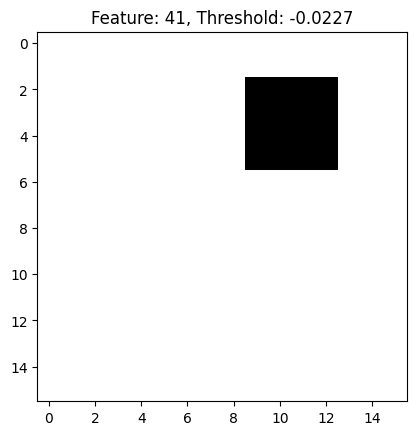

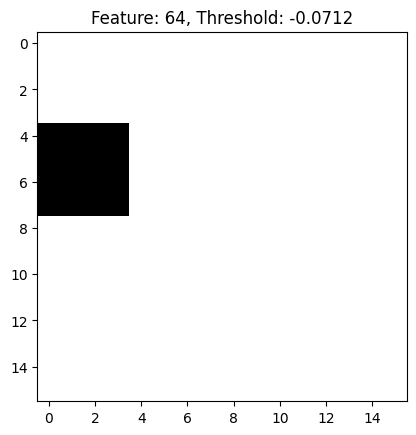

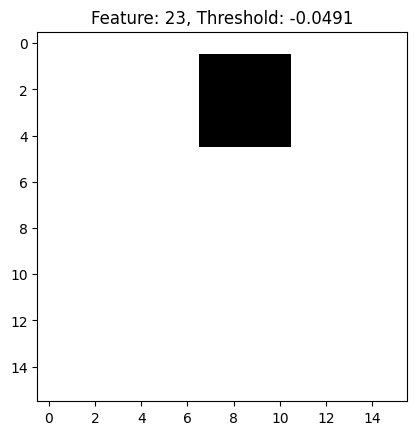

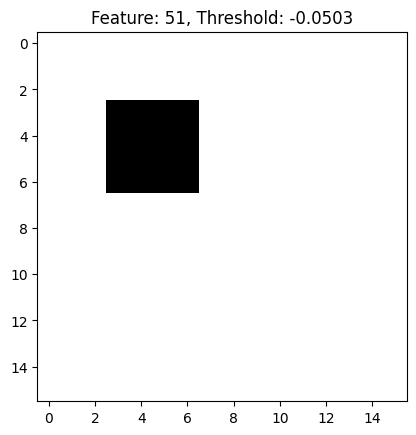

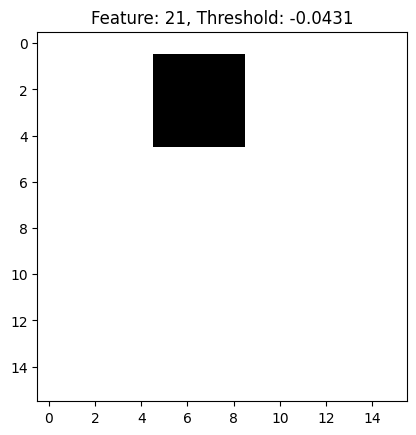

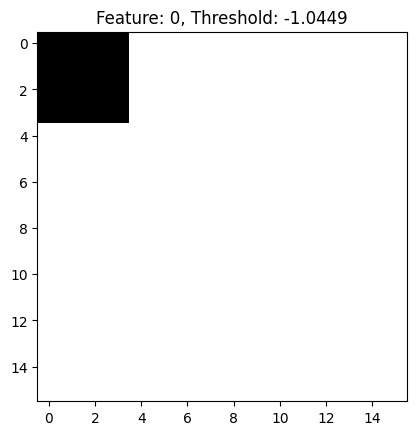

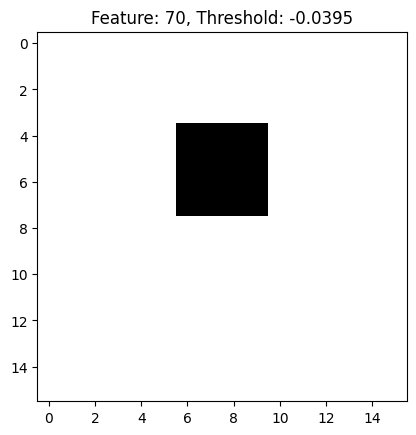

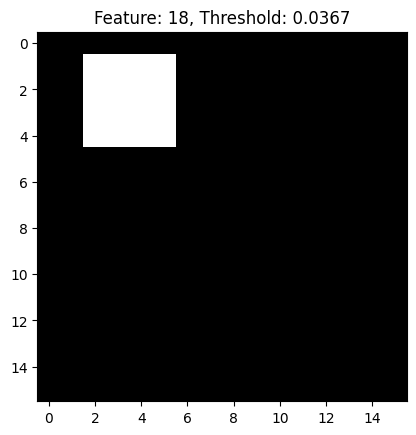

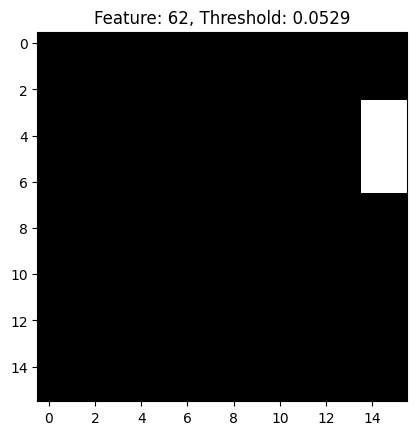

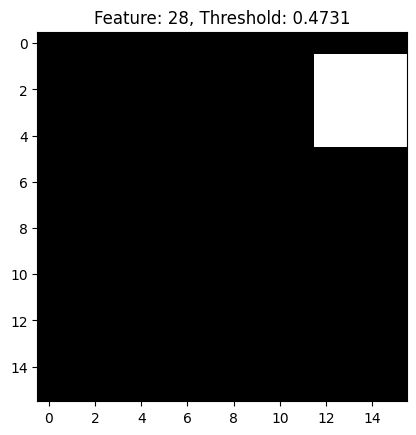

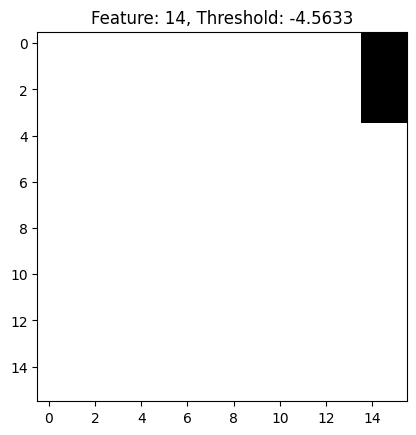

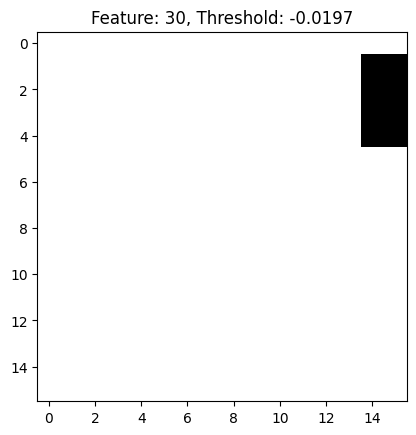

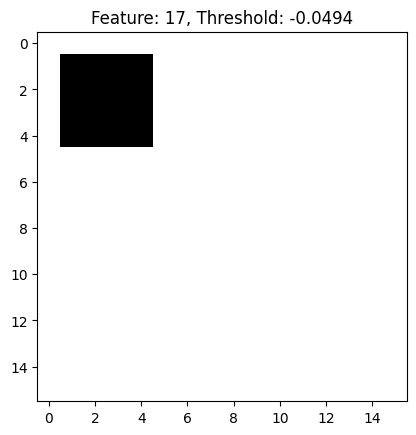

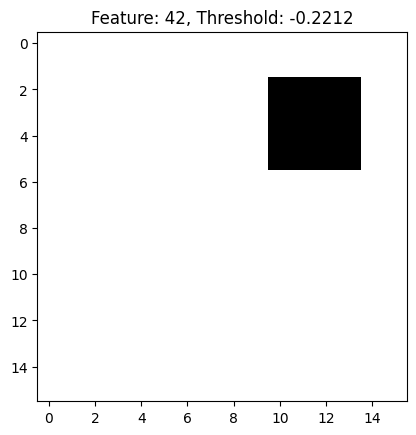

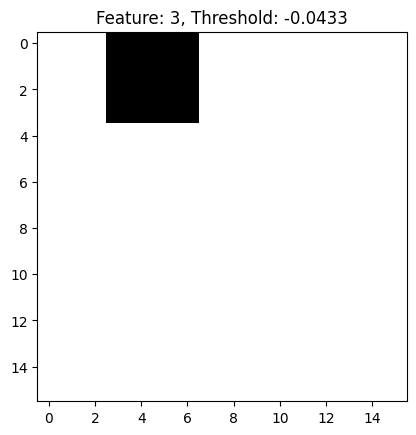

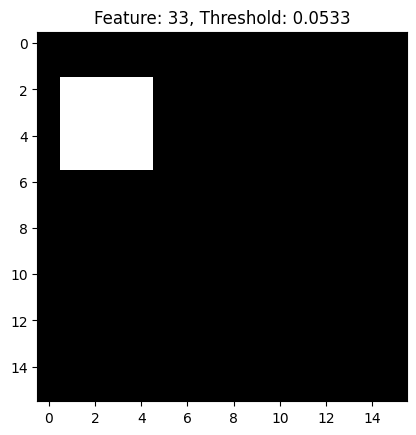

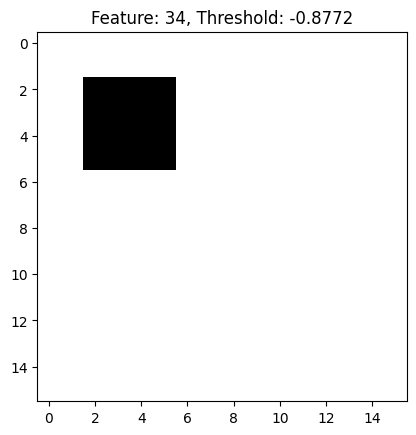

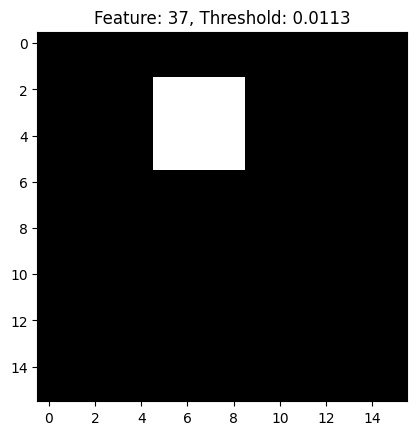

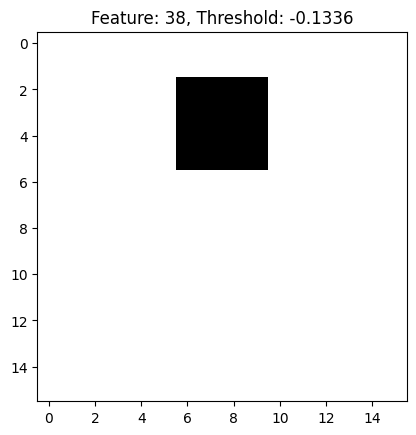

In [15]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt

# Parse the XML file
tree = ET.parse('/Users/huytrq/Workspace/unicas/AIA&ML/Wrist-Fracture-Detection/haar_training/opencv-cascade-tracker/data/cascade.xml')
root = tree.getroot()

# Find the correct path to the 'stages' element
cascade = root.find('cascade')
stages = cascade.find('stages')

# Function to extract HAAR filters from the cascade XML
def extract_haar_filters(stages):
    filters = []
    for stage in stages:
        for weak_classifier in stage.find('weakClassifiers'):
            internal_nodes = weak_classifier.find('internalNodes').text.split()
            filter_info = {
                'feature': int(internal_nodes[2]),
                'threshold': float(internal_nodes[3])
            }
            filters.append(filter_info)
    return filters

# Extract filters
haar_filters = extract_haar_filters(stages)

# Function to visualize a single HAAR filter
def visualize_haar_filter(filter_info, size=(16, 16)):
    feature = filter_info['feature']
    threshold = filter_info['threshold']
    
    # Creating a blank image
    img = np.zeros(size)
    
    # Simulating a simple visualization by placing a rectangle
    # This is a simplified example, actual HAAR filters are more complex
    top_left = (feature % size[1], feature // size[1])
    bottom_right = (top_left[0] + 4, top_left[1] + 4)
    
    img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = threshold
    
    plt.imshow(img, cmap='gray')
    plt.title(f'Feature: {feature}, Threshold: {threshold:.4f}')
    # plt.axis('off')
    plt.show()

# Visualize all HAAR filters
for filter_info in haar_filters:
    visualize_haar_filter(filter_info)
